In [1]:
import os, re, glob, time, json, warnings, math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

print("Torch:", torch.__version__, "| CUDA:", torch.version.cuda, "| cuda_available:", torch.cuda.is_available())
try:
    import numpy as np
    import numpy
    print("NumPy:", numpy.__version__)
except Exception as e:
    print("NumPy import issue:", e)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Torch: 2.5.1+cu121 | CUDA: 12.1 | cuda_available: True
NumPy: 1.26.4
Device: cuda


In [3]:
DATA_DIR = "perg/csv"  # <-- change path if needed

NEED_DATA = "per_eye_avg" not in globals()

In [4]:
try:
    from scipy.signal import butter, filtfilt, welch
    from scipy.stats import skew, kurtosis
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False
    def skew(x): return 0.0
    def kurtosis(x): return 0.0

if NEED_DATA:
    def _estimate_fs(time_series):
        try:
            t = pd.to_datetime(time_series, format="%Y-%m-%d %H:%M:%S.%f")
            dt = (t.view("int64")[1:] - t.view("int64")[:-1]) / 1e9
            return float(1.0 / np.median(dt))
        except Exception:
            try:
                vals = pd.to_numeric(time_series, errors="coerce").to_numpy(dtype=float)
                dt = np.diff(vals) / 1000.0
                return float(1.0 / np.median(dt))
            except Exception:
                return 1700.0

    def load_per_eye_table(data_dir):
        demo_path = os.path.join(data_dir, "participants_info.csv") 
        if not os.path.exists(demo_path):
            raise FileNotFoundError(f"participants_info.csv not found in {data_dir}")
        demo = pd.read_csv(demo_path)
        demo.columns = [c.strip() for c in demo.columns]

        files = sorted(glob.glob(os.path.join(data_dir, "[0-9][0-9][0-9][0-9].csv")))
        rows = []
        time_pat = re.compile(r'^TIME_(\d+)$')
        re_pat   = re.compile(r'^RE_(\d+)$')
        le_pat   = re.compile(r'^LE_(\d+)$')

        for fp in files:
            rec = pd.read_csv(fp)
            rec.columns = [c.strip() for c in rec.columns]
            rec_id = int(Path(fp).stem)
            cols = set(rec.columns)

            # discover repeats k
            ks = set()
            for c in cols:
                for pat in (time_pat, re_pat, le_pat):
                    m = pat.match(c)
                    if m: ks.add(int(m.group(1)))
            if not ks: ks = {1}

            for k in sorted(ks):
                time_col = f"TIME_{k}" if f"TIME_{k}" in cols else ("TIME" if "TIME" in cols else None)
                re_col   = f"RE_{k}"   if f"RE_{k}"   in cols else ("RE" if "RE" in cols else None)
                le_col   = f"LE_{k}"   if f"LE_{k}"   in cols else ("LE" if "LE" in cols else None)
                fs = _estimate_fs(rec[time_col]) if time_col is not None else 1700.0
                for eye, col in (("RE", re_col), ("LE", le_col)):
                    if col and col in rec.columns:
                        sig = pd.to_numeric(rec[col], errors="coerce").to_numpy(dtype=float)
                        rows.append({"record_id": rec_id, "eye": eye, "repeat": k,
                                     "n_samples": len(sig), "fs_hz": float(fs), "signal": sig})

        per_eye = pd.DataFrame(rows)
        key_col = "id_record" if "id_record" in demo.columns else "record_id"
        per_eye = per_eye.merge(demo, left_on="record_id", right_on=key_col, how="left")

        # targets
        if "diagnosis1" not in per_eye.columns:
            warnings.warn("diagnosis1 not found; default y_class=0")
            per_eye["y_class"] = 0
        else:
            per_eye["y_class"] = (per_eye["diagnosis1"].fillna("Normal").ne("Normal")).astype(int)

        re_col = next((c for c in per_eye.columns if c.lower() in ("va_re_logmar","logmar_re","va_re")), None)
        le_col = next((c for c in per_eye.columns if c.lower() in ("va_le_logmar","logmar_le","va_le")), None)
        per_eye["y_reg"] = np.where(per_eye["eye"].eq("RE"), per_eye.get(re_col), per_eye.get(le_col))
        return per_eye

    def baseline_and_filter(x, fs, baseline_ms=(0,10), band=(1.0,100.0)):
        x = np.asarray(x, dtype=float)
        if not np.isfinite(fs) or fs <= 0: fs = 1700.0
        n0 = max(1, int(fs*baseline_ms[1]/1000.0))
        y = x - float(np.nanmean(x[:n0]))
        if SCIPY_OK and band is not None:
            lo, hi = band
            if hi >= fs/2.0: hi = fs/2.0 - 1.0
            if hi > lo and hi > 0:
                b,a = butter(2, [lo/(fs/2.0), hi/(fs/2.0)], btype="band")
                y = filtfilt(b,a,y,method="gust")
        s = np.nanstd(y)
        if s > 1e-8: y = (y - np.nanmean(y)) / s
        return y

    def average_repeats(per_eye):
        rows = []
        for (rec, eye), grp in per_eye.groupby(["record_id", "eye"]):
            signals = []
            for _, r in grp.iterrows():
                fs = float(r.get("fs_hz", 1700.0)) if pd.notna(r.get("fs_hz")) else 1700.0
                sig = baseline_and_filter(r["signal"], fs)
                signals.append(sig)
            L = min(len(s) for s in signals)
            signals = [s[:L] for s in signals]
            avg_sig = np.mean(np.stack(signals, axis=0), axis=0)
            rows.append({
                "record_id": rec, "eye": eye, "signal": avg_sig,
                "fs_hz": float(grp["fs_hz"].iloc[0]) if pd.notna(grp["fs_hz"].iloc[0]) else 1700.0,
                "y_class": int(grp["y_class"].iloc[0]),
                "y_reg": float(grp["y_reg"].iloc[0]) if pd.notna(grp["y_reg"].iloc[0]) else np.nan,
                "n_repeats": len(grp)
            })
        return pd.DataFrame(rows)

    print("[data] building per_eye_avg …")
    per_eye = load_per_eye_table(DATA_DIR)
    per_eye_avg = average_repeats(per_eye)
    print("per_eye:", per_eye.shape, "| per_eye_avg:", per_eye_avg.shape)
else:
    print("[data] using existing per_eye_avg in notebook.")

# expose baseline_and_filter if not defined
if "baseline_and_filter" not in globals():
    def baseline_and_filter(x, fs, baseline_ms=(0,10), band=(1.0,100.0)):
        x = np.asarray(x, dtype=float)
        n0 = max(1, int(fs*baseline_ms[1]/1000.0))
        y = x - float(np.nanmean(x[:n0]))
        s = np.nanstd(y)
        if s > 1e-8: y = (y - np.nanmean(y)) / s
        return y

[data] building per_eye_avg …


C:\Users\kulde\AppData\Local\Temp\ipykernel_22396\3230523505.py:14: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  dt = (t.view("int64")[1:] - t.view("int64")[:-1]) / 1e9
C:\Users\kulde\AppData\Local\Temp\ipykernel_22396\3230523505.py:14: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  dt = (t.view("int64")[1:] - t.view("int64")[:-1]) / 1e9
C:\Users\kulde\AppData\Local\Temp\ipykernel_22396\3230523505.py:14: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  dt = (t.view("int64")[1:] - t.view("int64")[:-1]) / 1e9
C:\Users\kulde\AppData\Local\Temp\ipykernel_22396\3230523505.py:14: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  dt = (t.

per_eye: (1354, 20) | per_eye_avg: (672, 7)


In [5]:
def prepare_signals(df, target_len=2048):
    X, y, groups = [], [], []
    for _, r in df.iterrows():
        fs = float(r.get("fs_hz", 1700.0)) if pd.notna(r.get("fs_hz")) else 1700.0
        x = baseline_and_filter(r["signal"], fs).astype(np.float32)
        if len(x) >= target_len:
            start = (len(x) - target_len)//2
            x = x[start:start+target_len]
        else:
            pad = target_len - len(x)
            left = pad//2
            right = pad - left
            x = np.pad(x, (left, right), mode="constant")
        X.append(x[None, :])  # (1,L)
        y.append(int(r["y_class"]))
        groups.append(int(r["record_id"]))
    X = np.stack(X, axis=0)
    y = np.array(y, dtype=np.int64)
    groups = np.array(groups, dtype=np.int64)
    return X, y, groups

TARGET_LEN = 2048  # divisible by 4 for two MaxPool(2)
X_all, y_all, groups_all = prepare_signals(per_eye_avg, target_len=TARGET_LEN)
print("Tensor pack:", X_all.shape, y_all.shape)

Tensor pack: (672, 1, 2048) (672,)


In [ ]:
import sys


c:\Users\kulde\anaconda3\python.exe


In [ ]:
print(sys.executable)

In [7]:
import torch

# Check if CUDA is available and print the result
is_cuda_available = torch.cuda.is_available()
print(f"Is CUDA available? {is_cuda_available}")

# If it is, print the name of your GPU
if is_cuda_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")

Is CUDA available? True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [8]:
class PERGAugSet(Dataset):
    def __init__(self, X, y, train=True,
                 p_noise=0.5, p_shift=0.5, p_scale=0.5,
                 noise_std=0.03, max_shift=40, scale_range=(0.9, 1.1)):
        self.X = X; self.y = y; self.train = train
        self.p_noise = p_noise; self.p_shift = p_shift; self.p_scale = p_scale
        self.noise_std = noise_std; self.max_shift = max_shift
        self.scale_lo, self.scale_hi = scale_range

    def __len__(self): return len(self.y)

    def _augment(self, x):
        L = x.shape[-1]
        if np.random.rand() < self.p_shift and self.max_shift > 0:
            k = np.random.randint(-self.max_shift, self.max_shift+1)
            x = np.roll(x, k, axis=-1)
        if np.random.rand() < self.p_scale:
            s = np.random.uniform(self.scale_lo, self.scale_hi)
            x = x * s
        if np.random.rand() < self.p_noise:
            x = x + np.random.randn(*x.shape).astype(np.float32) * self.noise_std
        return x

    def __getitem__(self, idx):
        x = self.X[idx]; y = self.y[idx]
        if self.train: x = self._augment(x.copy())
        try:
            xt = torch.from_numpy(x)
            yt = torch.tensor(y, dtype=torch.long)
        except Exception:
            xt = torch.tensor(x.copy(), dtype=torch.float32)
            yt = torch.tensor(int(y), dtype=torch.long)
        return xt, yt

# ============================
# 3) ResNet-ish 1D CNN with correct "same" padding
# ============================
class ResidualBlock1D(nn.Module):
    def __init__(self, c_in, c_out, k=7, dilation=1, dropout=0.1):
        super().__init__()
        eff_k = (k - 1) * dilation + 1
        pad1  = eff_k // 2
        pad2  = 1  # for k=3, dilation=1
        self.proj = nn.Identity() if c_in == c_out else nn.Conv1d(c_in, c_out, kernel_size=1)
        self.net = nn.Sequential(
            nn.Conv1d(c_in, c_out, kernel_size=k, padding=pad1, dilation=dilation, stride=1, bias=False),
            nn.BatchNorm1d(c_out),
            nn.ReLU(inplace=True),
            nn.Conv1d(c_out, c_out, kernel_size=3, padding=pad2, dilation=1, stride=1, bias=False),
            nn.BatchNorm1d(c_out),
            nn.Dropout(dropout)
        )
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        return self.act(self.net(x) + self.proj(x))

class PERGResNet(nn.Module):
    def __init__(self, n_classes=2, base=32, dropout=0.2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(1, base, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm1d(base),
            nn.ReLU(inplace=True),
        )
        self.stage1 = ResidualBlock1D(base,   base,   k=7, dilation=1, dropout=dropout)
        self.pool1  = nn.MaxPool1d(2)   # L -> L/2
        self.stage2 = ResidualBlock1D(base,   base*2, k=5, dilation=2, dropout=dropout)
        self.pool2  = nn.MaxPool1d(2)   # L/2 -> L/4
        self.stage3 = ResidualBlock1D(base*2, base*4, k=3, dilation=4, dropout=dropout)
        self.head   = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(base*4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes),
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x); x = self.pool1(x)
        x = self.stage2(x); x = self.pool2(x)
        x = self.stage3(x)
        return self.head(x)
    
    
# ===========================
# Simple 1D CNN Model
# ===========================
class Simple1DCNN(nn.Module):
    def __init__(self, n_classes=2, base_filters=32, dropout_rate=0.2):
        super().__init__()
        
        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=base_filters, kernel_size=7, padding=3, bias=False),
            nn.BatchNorm1d(base_filters),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2) # Length -> Length / 2
        )
        
        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=base_filters, out_channels=base_filters*2, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm1d(base_filters*2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2) # Length -> Length / 4
        )
        
        # Convolutional Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv1d(in_channels=base_filters*2, out_channels=base_filters*4, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm1d(base_filters*4),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2) # Length -> Length / 8
        )
        
        # Classifier Head
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1), # Reduces length to 1
            nn.Flatten(),
            nn.Linear(base_filters*4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(128, n_classes)
        )
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.head(x)
        return x    

In [9]:
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
tr_idx, te_idx = next(cv.split(X_all, y_all, groups_all))
Xtr, ytr = X_all[tr_idx], y_all[tr_idx]
Xte, yte = X_all[te_idx], y_all[te_idx]

train_ds = PERGAugSet(Xtr, ytr, train=True,  noise_std=0.04, max_shift=64, scale_range=(0.9,1.1))
valid_ds = PERGAugSet(Xte, yte, train=False)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# class weights to handle any imbalance
class_counts = np.bincount(ytr, minlength=2).astype(float)
class_weights = class_counts.sum() / (2.0 * np.maximum(class_counts, 1.0))
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)


In [ ]:
model = Simple1DCNN(n_classes=2, base_filters=32, dropout_rate=0.2).to(device)

#model = PERGResNet(n_classes=2, base=32, dropout=0.2).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="max", patience=3, factor=0.5)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

def evaluate(model, loader):
    model.eval()
    tot, n = 0.0, 0
    all_prob, all_true = [], []
    with torch.no_grad():
        for xb,yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits = model(xb)
                loss = crit(logits, yb)
            tot += float(loss.item()) * len(yb)
            n += len(yb)
            prob = torch.softmax(logits, dim=1)[:,1]
            all_prob.append(prob.detach().cpu().numpy())
            all_true.append(yb.detach().cpu().numpy())
    all_prob = np.concatenate(all_prob)
    all_true = np.concatenate(all_true)
    acc = accuracy_score(all_true, (all_prob>=0.5).astype(int))
    f1  = f1_score(all_true, (all_prob>=0.5).astype(int))
    try:
        auc = roc_auc_score(all_true, all_prob)
    except Exception:
        auc = np.nan
    return tot/n, acc, f1, auc, all_true, all_prob

EPOCHS = 25
best_auc, best_state, bad_epochs = -1, None, 0
hist = {"tr_loss":[], "va_loss":[], "va_acc":[], "va_f1":[], "va_auc":[]}

for ep in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    tr_tot, tr_n = 0.0, 0
    for xb,yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            logits = model(xb)
            loss = crit(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        tr_tot += float(loss.item()) * len(yb)
        tr_n += len(yb)

    tr_loss = tr_tot / max(1,tr_n)
    va_loss, va_acc, va_f1, va_auc, y_true, y_prob = evaluate(model, valid_loader)

    hist["tr_loss"].append(tr_loss)
    hist["va_loss"].append(va_loss)
    hist["va_acc"].append(va_acc)
    hist["va_f1"].append(va_f1)
    hist["va_auc"].append(va_auc)

    sched.step(va_auc if not math.isnan(va_auc) else 0.0)

    print(f"epoch {ep:02d} | tr_loss {tr_loss:.4f} | va_loss {va_loss:.4f} "
          f"| va_acc {va_acc:.3f} | va_f1 {va_f1:.3f} | va_auc {va_auc:.3f} | {time.time()-t0:.1f}s")

    # early stopping on AUC
    if va_auc > best_auc + 1e-4:
        best_auc = va_auc
        best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= 6:
            print("Early stopping.")
            break

# load best
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k,v in best_state.items()})


C:\Users\kulde\AppData\Local\Temp\ipykernel_22396\3085754854.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))


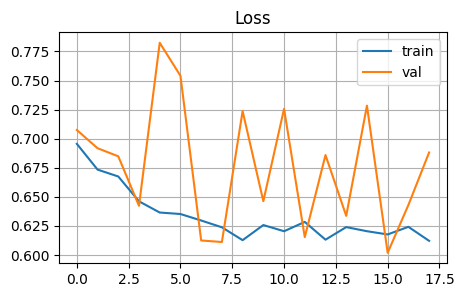

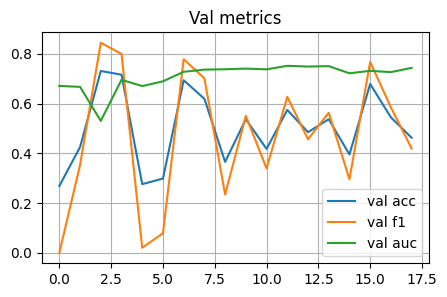

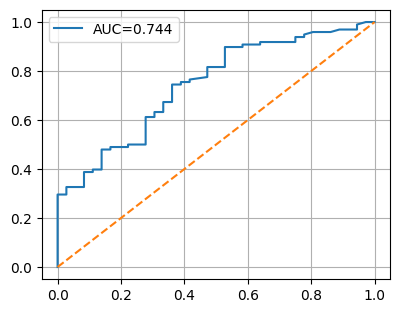

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
plt.figure(figsize=(5,3)); plt.plot(hist["tr_loss"], label="train"); plt.plot(hist["va_loss"], label="val")
plt.legend(); plt.title("Loss"); plt.grid(True); plt.show()
plt.figure(figsize=(5,3)); plt.plot(hist["va_acc"], label="val acc"); plt.plot(hist["va_f1"], label="val f1"); plt.plot(hist["va_auc"], label="val auc")
plt.legend(); plt.title("Val metrics"); plt.grid(True); plt.show()
fpr,tpr,_ = roc_curve(y_true,y_prob); plt.figure(figsize=(4.5,3.5))
plt.plot(fpr,tpr,label=f"AUC={roc_auc_score(y_true,y_prob):.3f}"); plt.plot([0,1],[0,1],'--'); plt.legend(); plt.grid(True); plt.show()